# Features

Target Variable: Next 3 Day The Price Go Up or Down? (Up-1 , Down-0)

Features: 
1. ATR14
2. Rolling Std 20
3. Normalized True Range
4. ATR / Std ratio
5. ROC5
6. RSI10
7. Candle body %
8. Volume spike
9. return_1d
10. return_3d
11. return_5d


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../data/processed/new_QQQ_data.csv",
                 parse_dates=["Date"],
                 index_col="Date")

df.head()

,Open,High,Low,Close,Volume
Date,,,,,
1999-03-10,51.12500,51.156250,50.28125,43.478279,5232000
1999-03-11,51.43750,51.734375,50.31250,43.691170,9688600
1999-03-12,51.12500,51.156250,49.65625,42.626823,8743600
1999-03-15,50.43750,51.562500,49.90625,43.850815,6369000
1999-03-16,51.71875,52.156250,51.15625,44.223331,4905800


In [3]:
df.info()
df.isna().sum()
df.describe()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6715 entries, 1999-03-10 to 2025-11-14
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    6715 non-null   float64
 1   High    6715 non-null   float64
 2   Low     6715 non-null   float64
 3   Close   6715 non-null   float64
 4   Volume  6715 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 314.8 KB


,Open,High,Low,Close,Volume
count,6715.000000,6715.000000,6715.000000,6715.000000,6.715000e+03
mean,139.788287,140.879209,138.572581,133.952759,6.501436e+07
std,138.779314,139.681375,137.754320,140.079923,4.827187e+07
min,19.940001,20.530001,19.760000,17.080540,3.302000e+06
25%,42.955000,43.400002,42.510000,37.237888,3.092820e+07
50%,74.300003,75.019997,73.550003,66.245987,5.217320e+07
75%,181.215004,182.650002,179.934998,174.591995,8.556610e+07
max,635.590027,637.010010,630.250000,635.770020,6.167723e+08


In [4]:
def compute_atr(df, window=14):
    """
    Calculate ATR (average true range)
    """
    high_low = df["High"] - df["Low"]
    high_close = np.abs(df["High"] - df["Close"].shift())
    low_close  = np.abs(df["Low"] - df["Close"].shift())

    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(window).mean()
    return atr


Volatility Feature

In [6]:
df["returns"] = df["Close"].pct_change()


In [7]:
# ATR
df["ATR14"] = compute_atr(df, 14)

# Rolling standard deviation (20 days)
df["vol_std20"] = df["returns"].rolling(20).std()

# Normalized true range
df["norm_tr"] = (df["High"] - df["Low"]) / df["Close"]

# ATR / Std ratio
df["vol_ratio"] = df["ATR14"] / df["vol_std20"]


Momentum Feature

In [8]:
# Rate of Change (5 days)
df["roc5"] = df["Close"].pct_change(5)

# RSI (10)
def compute_rsi(series, window=10):
    delta = series.diff()
    gain = delta.clip(lower=0).rolling(window).mean()
    loss = -delta.clip(upper=0).rolling(window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df["rsi10"] = compute_rsi(df["Close"], 10)


Candle Structure Feature

In [10]:
# Candle body percentage
df["candle_body_pct"] = (df["Close"] - df["Open"]).abs() / (df["High"] - df["Low"]).replace(0, np.nan)

# Handle division by zero
df["candle_body_pct"] = df["candle_body_pct"].fillna(0)



Volume Feature

In [11]:
df["vol_ma20"] = df["Volume"].rolling(20).mean()
df["vol_spike"] = df["Volume"] / df["vol_ma20"]


Lagged Returns Feature

In [12]:
df["return_1d"] = df["Close"].pct_change(1)
df["return_3d"] = df["Close"].pct_change(3)
df["return_5d"] = df["Close"].pct_change(5)


Target Variable

In [13]:
df["future_3d_return"] = df["Close"].shift(-3) / df["Close"] - 1
df["target"] = (df["future_3d_return"] > 0).astype(int)

In [14]:
df_clean = df.dropna().copy()
df_clean.head()


,Open,High,Low,Close,Volume,ATR14,returns,vol_std20,norm_tr,vol_ratio,roc5,rsi10,candle_body_pct,vol_ma20,vol_spike,return_1d,return_3d,return_5d,future_3d_return,target
Date,,,,,,,,,,,,,,,,,,,,
1999-04-08,54.93750,55.734375,53.812500,47.230087,7952400,8.781853,0.007950,0.022590,0.040692,388.749281,0.057177,76.058700,4.010361,7331370.0,1.084709,0.007950,-0.000563,0.057177,-0.014085,0
1999-04-09,55.37500,55.937500,55.218750,47.522800,4946800,8.797062,0.006198,0.022593,0.015124,389.363698,0.042007,71.621792,10.924799,7094280.0,0.697294,0.006198,0.003653,0.042007,-0.053752,0
1999-04-12,54.50000,55.812500,54.437500,47.203495,10934000,8.821242,-0.006719,0.021737,0.029129,405.808671,-0.001126,73.320225,5.306549,7203800.0,1.517810,-0.006719,0.007382,-0.001126,-0.034386,0
1999-04-13,55.78125,55.906250,54.250000,46.564873,9962200,8.912809,-0.013529,0.021396,0.035569,416.566479,-0.016578,57.834057,5.564605,7383460.0,1.349259,-0.013529,-0.014085,-0.016578,-0.049714,0
1999-04-14,55.37500,55.437500,52.507812,44.968361,21253800,8.908173,-0.034286,0.022925,0.065150,388.579719,-0.040318,47.358470,3.552133,8200860.0,2.591655,-0.034286,-0.053752,-0.040318,-0.062130,0


Check Target Distribution

In [15]:
df_clean["target"].value_counts(normalize=True)


target
1    0.567394
0    0.432606
Name: proportion, dtype: float64

Check Feature Correlation

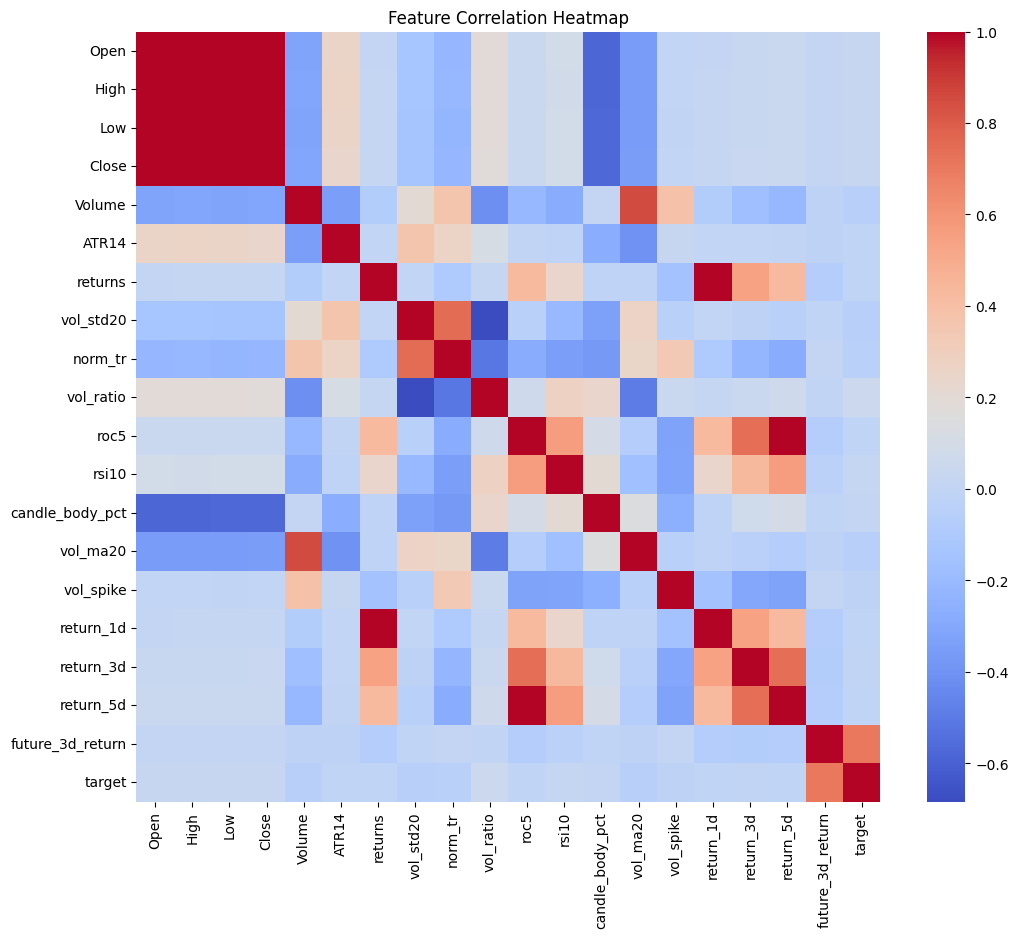

In [17]:

plt.figure(figsize=(12, 10))
sns.heatmap(df_clean.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


- Remove OHLC from feature (Meaningless they are price features)
- Remove future 3day return (Wrong feature)
- Remove vol MA 20 (Already have volume spike)

Save Dataset

In [18]:
final_features = [
    "ATR14",
    "vol_std20",
    "norm_tr",
    "vol_ratio",
    "roc5",
    "rsi10",
    "candle_body_pct",
    "vol_spike",
    "return_1d",
    "return_3d",
    "return_5d",
    "target"
]

df_final = df_clean[final_features].copy()
df_final.head()


,ATR14,vol_std20,norm_tr,vol_ratio,roc5,rsi10,candle_body_pct,vol_spike,return_1d,return_3d,return_5d,target
Date,,,,,,,,,,,,
1999-04-08,8.781853,0.022590,0.040692,388.749281,0.057177,76.058700,4.010361,1.084709,0.007950,-0.000563,0.057177,0
1999-04-09,8.797062,0.022593,0.015124,389.363698,0.042007,71.621792,10.924799,0.697294,0.006198,0.003653,0.042007,0
1999-04-12,8.821242,0.021737,0.029129,405.808671,-0.001126,73.320225,5.306549,1.517810,-0.006719,0.007382,-0.001126,0
1999-04-13,8.912809,0.021396,0.035569,416.566479,-0.016578,57.834057,5.564605,1.349259,-0.013529,-0.014085,-0.016578,0
1999-04-14,8.908173,0.022925,0.065150,388.579719,-0.040318,47.358470,3.552133,2.591655,-0.034286,-0.053752,-0.040318,0


In [19]:
df_clean.to_csv("C:/Users/USER/Documents/QQQ Project/data/processed/qqq_features_classification.csv")
